
Classification Report (Empatica Model CNN):
               precision    recall  f1-score   support

           0       0.75      1.00      0.86       374
           1       1.00      0.66      0.80       374

    accuracy                           0.83       748
   macro avg       0.87      0.83      0.83       748
weighted avg       0.87      0.83      0.83       748


Classification Report (Samsung Model CNN):
               precision    recall  f1-score   support

           0       0.54      0.44      0.49       374
           1       0.53      0.62      0.57       374

    accuracy                           0.53       748
   macro avg       0.53      0.53      0.53       748
weighted avg       0.53      0.53      0.53       748



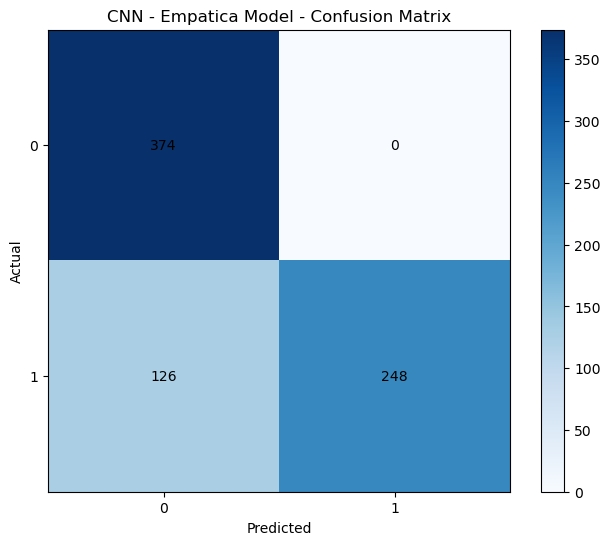

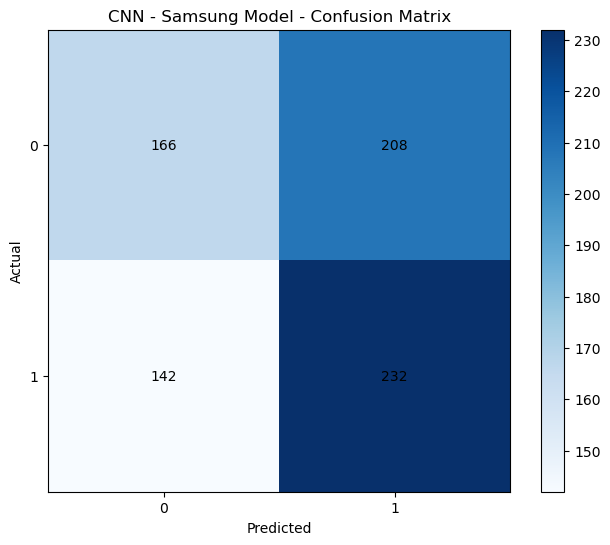

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("RandomForestWithPySpark").getOrCreate()

# Define file paths
training_file_path = "./data/6-data-split/z-score/a_training.csv"
testing_file_path = "./data/6-data-split/z-score/b_testing.csv"

# Load the dataset
training_df = spark.read.csv(training_file_path, header=True, inferSchema=True)
testing_df = spark.read.csv(testing_file_path, header=True, inferSchema=True)

# Define feature columns
feature_columns_empatica = ["empatica_bvp", "empatica_eda", "empatica_temp"]
feature_columns_samsung = ["samsung_bvp"]

# Assemble feature vector
assembler_empatica = VectorAssembler(
    inputCols=feature_columns_empatica, outputCol="features_empatica"
)
assembler_samsung = VectorAssembler(
    inputCols=feature_columns_samsung, outputCol="features_samsung"
)

# Train Random Forest models
rf_empatica = RandomForestClassifier(
    labelCol="CL", featuresCol="features_empatica", seed=5, maxDepth=10
)
rf_samsung = RandomForestClassifier(
    labelCol="CL", featuresCol="features_samsung", seed=5, maxDepth=10
)

# Create pipelines
pipeline_empatica = Pipeline(stages=[assembler_empatica, rf_empatica])
pipeline_samsung = Pipeline(stages=[assembler_samsung, rf_samsung])

# Train models
model_empatica = pipeline_empatica.fit(training_df)
model_samsung = pipeline_samsung.fit(training_df)

# Make predictions
predictions_empatica = model_empatica.transform(testing_df)
predictions_samsung = model_samsung.transform(testing_df)

# Extracting predicted and true labels for Empatica Model (CNN)
predictions_empatica_cnn = predictions_empatica.select("prediction", "CL")
y_pred_empatica_cnn = np.array(
    predictions_empatica_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_empatica_cnn = np.array(
    predictions_empatica_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)

# Extracting predicted and true labels for Samsung Model (CNN)
predictions_samsung_cnn = predictions_samsung.select("prediction", "CL")
y_pred_samsung_cnn = np.array(
    predictions_samsung_cnn.select("prediction").rdd.map(lambda x: x[0]).collect()
).astype(int)
y_true_samsung_cnn = np.array(
    predictions_samsung_cnn.select("CL").rdd.map(lambda x: x[0]).collect()
).astype(int)


# Calculate confusion matrices
conf_mat_empatica_cnn = np.zeros((2, 2))
conf_mat_samsung_cnn = np.zeros((2, 2))

for i in range(len(y_true_empatica_cnn)):
    conf_mat_empatica_cnn[y_true_empatica_cnn[i], y_pred_empatica_cnn[i]] += 1

for i in range(len(y_true_samsung_cnn)):
    conf_mat_samsung_cnn[y_true_samsung_cnn[i], y_pred_samsung_cnn[i]] += 1

# Print classification reports
print(
    "\nClassification Report (Empatica Model CNN):\n",
    classification_report(y_true_empatica_cnn, y_pred_empatica_cnn),
)
print(
    "\nClassification Report (Samsung Model CNN):\n",
    classification_report(y_true_samsung_cnn, y_pred_samsung_cnn),
)

# Plot confusion matrices
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat_empatica_cnn, cmap="Blues")
plt.title("CNN - Empatica Model - Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(conf_mat_empatica_cnn.shape[0]):
    for j in range(conf_mat_empatica_cnn.shape[1]):
        plt.text(
            j,
            i,
            str(int(conf_mat_empatica_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(conf_mat_samsung_cnn, cmap="Blues")
plt.title("CNN - Samsung Model - Confusion Matrix")
plt.colorbar()
plt.xticks([0, 1], ["0", "1"])
plt.yticks([0, 1], ["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(conf_mat_samsung_cnn.shape[0]):
    for j in range(conf_mat_samsung_cnn.shape[1]):
        plt.text(
            j,
            i,
            str(int(conf_mat_samsung_cnn[i, j])),
            ha="center",
            va="center",
            color="black",
        )

plt.show()

# Stop SparkSession
spark.stop()